## Entrega 2 (Grupo 12)
# *"Predicción de la edad de los abalones en Hobart, Tasmania"*

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, root_mean_squared_error
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn import linear_model
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.linear_model import Lasso

El siguiente paso en nuestro trabajo para predecir la edad de los abalones es plantear diferentes modelos de regresión. Primero, desarrollamos un modelo utilizando solo dos features con el objetivo **rings**, para evaluar su rendimiento. Posteriormente, elaboramos otro modelo con una mayor cantidad de features con el fin de compararlos y determinar cuál ofrece el mejor desempeño.

## Análisis y preprocesamiento de los datos

In [23]:
df = pd.read_csv("./abalone.csv")
df.head(5)

,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


El dataset estaba originalmente preprocesado para trabajar con redes neuronales, por lo que fue necesario transformar los valores a su escala original. Esto se logra multiplicando cada elemento continuo del conjunto por 200, según lo indicado en la documentación.

In [24]:
columns_to_rescale = ['Length', 'Diameter', 'Height', 'Whole_weight', 'Shucked_weight', 'Viscera_weight', 'Shell_weight']

df[columns_to_rescale] = df[columns_to_rescale] * 200
df.head(5)
df.shape

(4177, 9)

Luego de ajustar los valores a la escala correcta, realizamos un *scatterplot* del *target* en función de cada *feature* continuo para identificar posibles tendencias o valores atípicos en los datos.

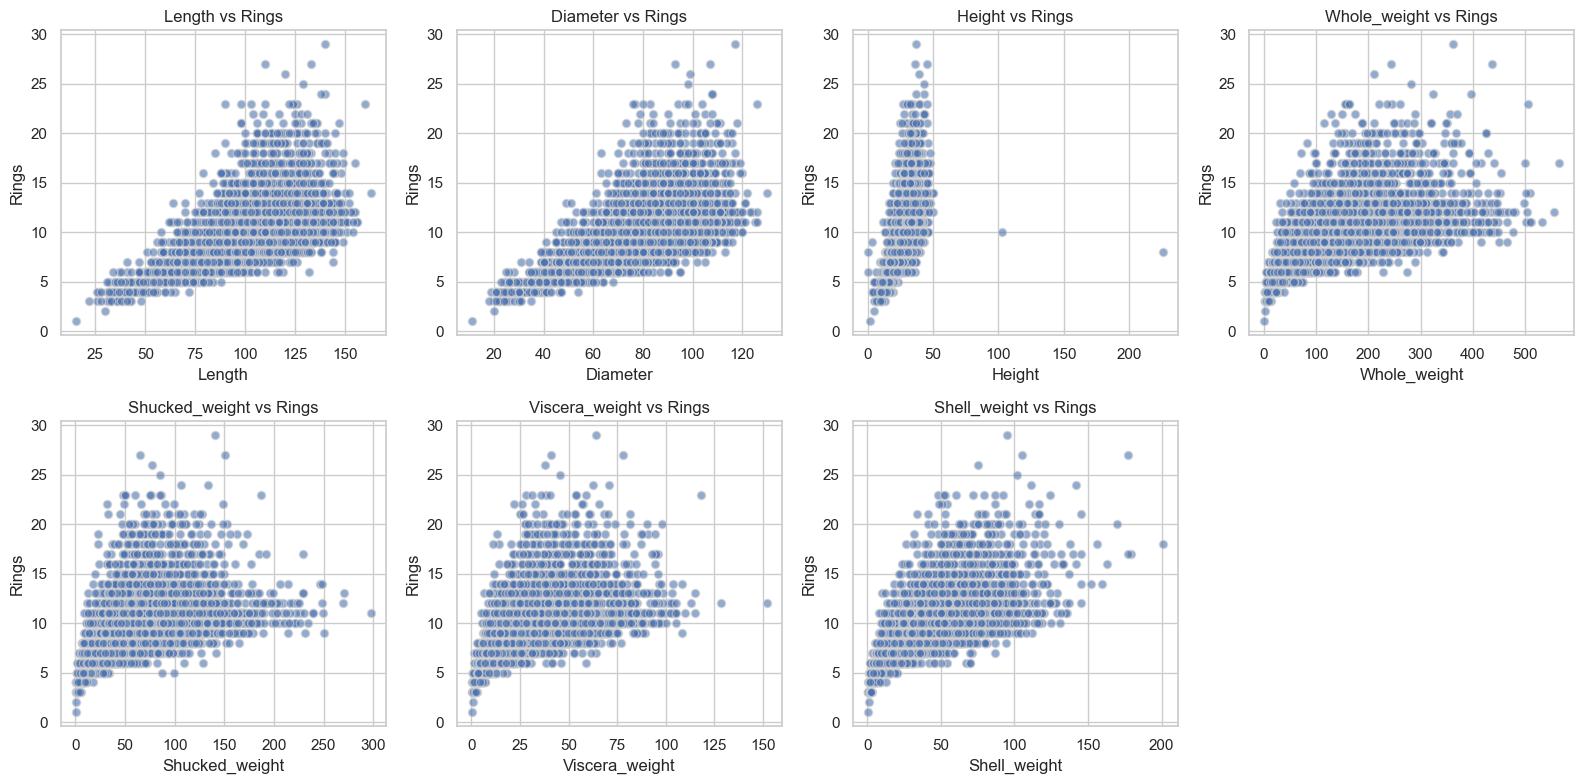

In [25]:
features= df.drop(columns=['Sex', 'Rings'], axis=0) #Nos quedamos solamente con los features continuos
target = df['Rings']

fig, axs = plt.subplots(2,4, figsize=(16, 8))
axs = axs.flatten()

for i, feature in enumerate(features.columns):
    axs[i].scatter(features[feature], target, alpha = 0.6, edgecolor= 'lightgray')
    axs[i].set_title(f'{feature} vs Rings')
    axs[i].set_xlabel(feature)
    axs[i].set_ylabel('Rings')

for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

Observamos que la variable `Height` tiene dos valores mucho mayores al rango de valores que toma en el 99% de los casos, lo que distorsiona la escala de los datos de `Height` en el *scatterplot* y también afectaría los modelos de regresión lineal que utilizaremos en los próximos pasos del trabajo, ya que estos modelos son sensibles a *outliers*.

In [26]:
df = df[(df['Height'] < 70)]

sum(df.value_counts())

4175

Volvimos a realizar un *scatterplot* del *target* en función de las *features* para mostrar cómo cambió la escala de `Height` luego del filtrado; a su vez, la cantidad de filas pasó de 4177 a 4175.

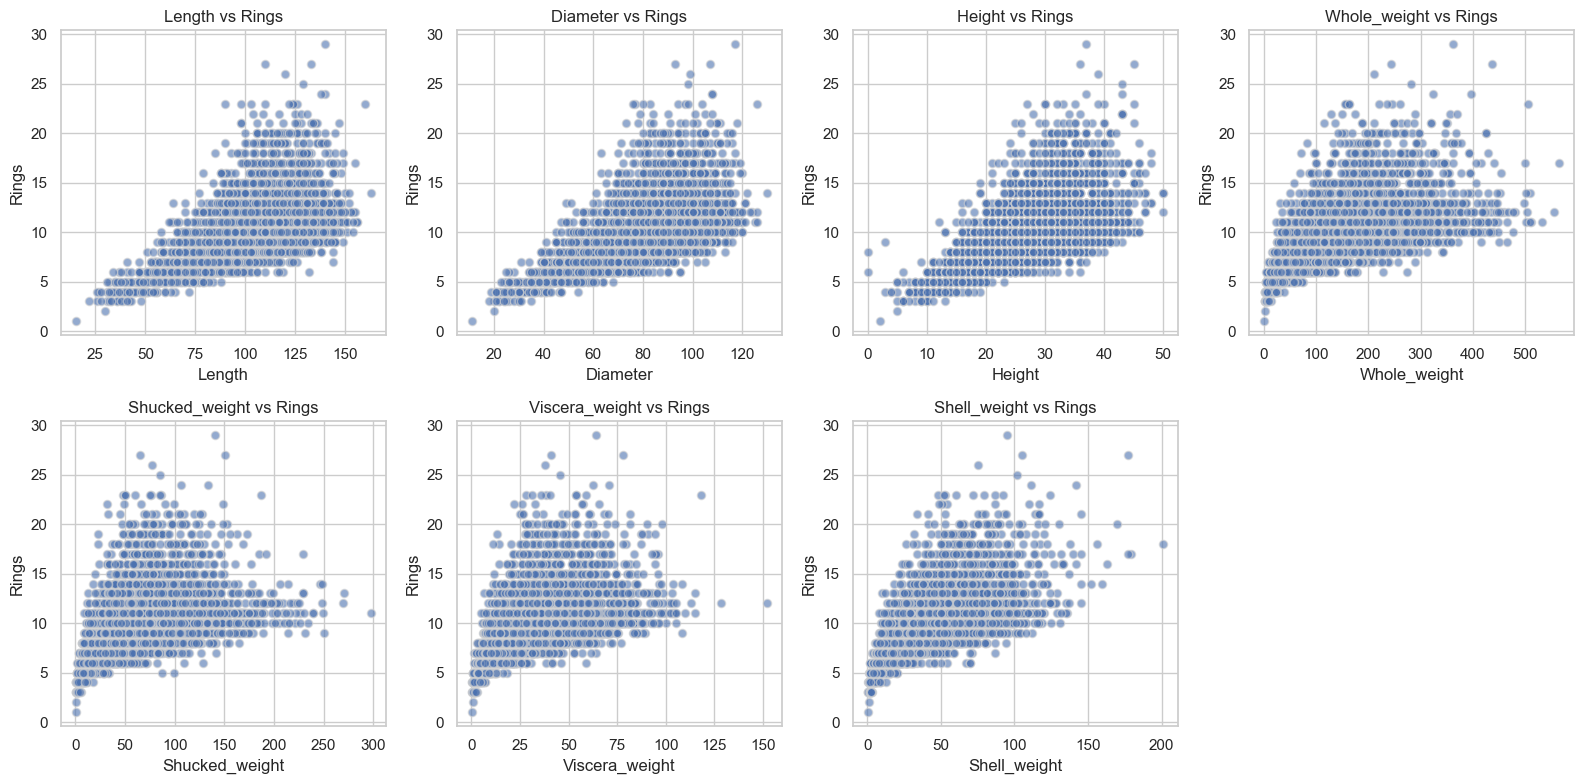

In [27]:
features= df.drop(columns=['Sex', 'Rings'], axis=0)
target = df['Rings']

fig, axs = plt.subplots(2,4, figsize=(16, 8))
axs = axs.flatten()

for i, feature in enumerate(features.columns):
    axs[i].scatter(features[feature], target, alpha = 0.6, edgecolor= 'lightgray')
    axs[i].set_title(f'{feature} vs Rings')
    axs[i].set_xlabel(feature)
    axs[i].set_ylabel('Rings')

for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()

## Modelo con dos features `Linear Regression (Benchmark)`

Como primer modelo, decidimos utilizar un modelo de regresión lineal `LinearRegression()`, utilizando solamente dos *features* del conjunto de datos: **`Length`** y **`Whole_weight`**. A su vez, este modelo será nuestro **benchmark** para comparar la performance con otros modelos.

Para medir la performance del modelo, utilizaremos las siguientes métricas de regresión:

- **R² (Coeficiente de Determinación)**: Esta métrica nos indica qué proporción de la variabilidad de la variable dependiente es explicada por las variables independientes en el modelo. Un valor más alto de R² sugiere que el modelo tiene un mejor ajuste a los datos.

- **RMSE (Root Mean Squared Error)**: El RMSE proporciona una medida del error en las predicciones del modelo, expresando la diferencia promedio entre los valores predichos y los valores reales. Un RMSE más bajo indica un mejor rendimiento del modelo.

Además, se utilizó **cross-validation** (validación cruzada) con 10 *folds* y con R² como métrica de performance, para evaluar la estabilidad y generalización del modelo. Esta técnica permite verificar cómo se desempeña el modelo en diferentes subconjuntos de los datos, asegurando que los resultados no sean simplemente un reflejo del conjunto de entrenamiento.

In [28]:
X = df[['Length', 'Whole_weight']]
y = df['Rings']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [29]:
def redondeo_primer_decimal(valor):
     # Convertir el valor a string y dividir en parte entera y decimal
    partes = str(valor).split(".")
    if len(partes) > 1 and len(partes[1]) > 0:  # Comprobar si hay decimales
        primer_decimal = int(partes[1][0])  # Obtener el primer decimal
        if primer_decimal >= 5:
            return int(valor) + 1  # Redondeo hacia arriba
        else:
            return int(valor)      # Redondeo hacia abajo
    else:
        return int(valor)  # Si no hay decimales, redondea normalmente

In [30]:
linear_reg = LinearRegression().fit(X_train, y_train)

# Predicciones para el entrenamiento y test
y_train_pred = linear_reg.predict(X_train)
y_test_pred = linear_reg.predict(X_test)

redondeo_vectorizado = np.vectorize(redondeo_primer_decimal)

y_train_pred_round = redondeo_vectorizado(y_train_pred)
y_test_pred_round = redondeo_vectorizado(y_test_pred)

In [31]:
# Cálculo del RMSE y R2 para el conjunto de entrenamiento
rmse_train = root_mean_squared_error(y_train, y_train_pred_round)
r2_train = r2_score(y_train, y_train_pred_round)

# Cálculo del RMSE y R2 para el conjunto de testeo
rmse_test = root_mean_squared_error(y_test, y_test_pred_round)
r2_test = r2_score(y_test, y_test_pred_round)

# Cálculo del cross-validation score
score = cross_val_score(linear_reg, X_train, y_train, cv=10, scoring='r2')

# Cálculo del residuo
residue = y_test - y_test_pred_round

# Creación del DataFrame con las métricas de rendimiento
lr_perf_df = pd.DataFrame({
    'rmse_train': [rmse_train],
    'rmse_test': [rmse_test],
    'R2_train': [r2_train],
    'R2_test': [r2_test],
    'cv_score_mean': [score.mean()],
    'cv_score_std': [score.std()],
    'model': 'Linear_Reg'
})

lr_perf_df

,rmse_train,rmse_test,R2_train,R2_test,cv_score_mean,cv_score_std,model
0,2.716971,2.615718,0.299204,0.319773,0.301502,0.038341,Linear_Reg


### Resumen de Performance

- **`RMSE`**:
  - **Entrenamiento**: 2.717
  - **Prueba**: 2.616

- **`R²`**:
  - **Entrenamiento**: 0.299
  - **Prueba**: 0.320
  - Aproximadamente el 32% de la variabilidad de la variable dependiente parece ser explicada por el modelo.

- **`Cross-Validation-Score`**:
  - **Promedio**: 0.302
  - **Desviación Estándar**: 0.038
  - Rendimiento moderado del modelo con una variabilidad razonable en diferentes particiones del conjunto de datos.

#### Procedimos a graficar las predicciones en función de los valores reales del *target* y la distribución de los residuos.

Text(0, 0.5, 'Prediction')

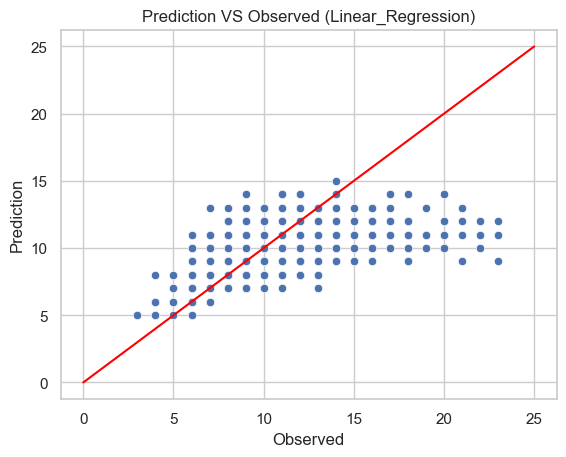

In [32]:
sns.scatterplot(x=y_test, y=y_test_pred_round) #Datos de testeo y la prediccion de los mismos

plt.plot([0,25],[0,25], color='red')
plt.title('Prediction VS Observed (Linear_Regression)')
plt.xlabel('Observed')
plt.ylabel('Prediction')

Text(0.5, 1.0, 'Residue  (Linear_Regression)')

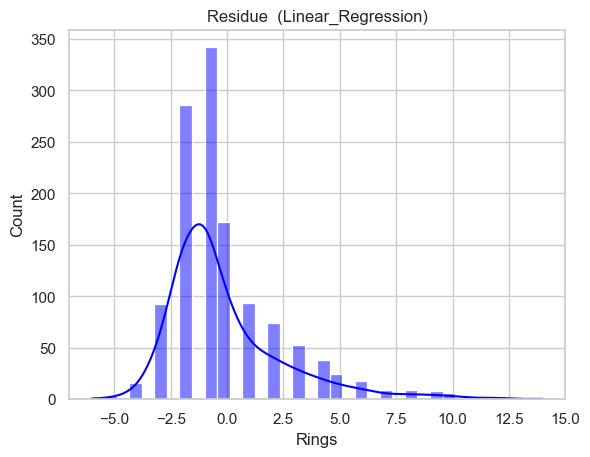

In [33]:
sns.histplot(x=residue, kde=True, color='blue')
plt.title('Residue  (Linear_Regression)')

### Conclusiones del Modelo `Linear Regression (Benchmark)`

El modelo `LinearRegression()` con solo dos *features*, `Length` y `Whole_weight`, no parece captar muy bien los patrones en los datos, con un `R²` en test de 0.320. También tiene un rango de error que podría considerarse elevado, con un `RMSE` de 2.616 en test, lo que representa aproximadamente el 8.966% del rango total del *target*. Otra observación es que, al ser el *`RMSE_train` > `RMSE_test`* y el *`R²_train` < `R²_test`*, parecería estar indicando que hay un **underfitting** del modelo.

En línea con lo anteriormente mencionado, en este *scatterplot* *"Predictions VS Observed (Linear Regression)"* podemos ver que el modelo parece tener un sesgo al subestimar gran parte de las predicciones a medida que la cantidad de anillos aumenta, lo que podría indicar un underfitting.

Observación: las predicciones del modelo `Linear regresión (Benchmark)` devuelven valores continuos con coma, pero el *target* contra el que se comparan las predicciones tiene saltos discretos de 1 unidad, por lo que todas las predicciones fueron redondeadas según el criterio: *if (parte_decimal >= 5) → (valor_redondeado = parte_entera + 1), else (valor_redondeado = parte_entera)*.

## Modelo con más de dos *features*: `Linear Regression (Lasso)`

Como segundo modelo, decidimos optar por `Linear_model.Lasso()` (Least Absolute Shrinkage and Selection Operator). Esta técnica no solo ayuda a simplificar el modelo a través de la regularización, sino que también selecciona las características más importantes, descartando aquellas que no aportan mucho. Como resultado, esperamos mejorar la capacidad predictiva del modelo y facilitar la interpretación de los resultados.

Reescalamos las *features* que contienen valores continuos utilizando `StandardScaler` para poder analizar el peso de los coeficientes de cada atributo. A la única variable categórica, `'Sex'`, se le aplicó `OneHotEncoding`, ya que al ser categórica, si no la transformamos, no podríamos utilizarla en nuestro modelo de regresión.

In [34]:
X = df[['Length', 'Diameter', 'Height', 'Whole_weight', 'Shucked_weight', 'Viscera_weight', 'Shell_weight','Sex']]
y = df['Rings']  

columnas_continuas = ['Length', 'Diameter', 'Height', 'Whole_weight', 'Shucked_weight', 'Viscera_weight', 'Shell_weight']
columnas_categoricas = ['Sex']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


preprocesador = ColumnTransformer([
    ('scaler', StandardScaler(), columnas_continuas),
    ('onehot', OneHotEncoder(drop='first'), columnas_categoricas)
])

lasso_pipeline = Pipeline([
    ('preprocesador', preprocesador),
    ('lasso', linear_model.Lasso(alpha=0.02, max_iter=1000))
])

In [35]:
lasso_reg_optimo = lasso_pipeline.fit(X_train, y_train)

lrlasso_train_pred = lasso_reg_optimo.predict(X_train)
lrlasso_test_pred = lasso_reg_optimo.predict(X_test)

lrlasso_train_pred_red = redondeo_vectorizado(lrlasso_train_pred)
lrlasso_test_pred_red = redondeo_vectorizado(lrlasso_test_pred)

In [36]:
# Cálculo del RMSE y R² para el conjunto de entrenamiento
rmse_train = root_mean_squared_error(y_train, lrlasso_train_pred_red)
r2_train = r2_score(y_train, lrlasso_train_pred_red)

# Cálculo del RMSE y R² para el conjunto de prueba
rmse_test = root_mean_squared_error(y_test, lrlasso_test_pred_red)
r2_test = r2_score(y_test, lrlasso_test_pred_red)

# Cálculo del cross-validation score
score = cross_val_score(lasso_reg_optimo, X_train, y_train, cv=10, scoring='r2')
# score_test = cross_val_score(lr_lasso, X_test, y_test, cv=10, scoring='r2')

residue = y_test - lrlasso_test_pred_red

# Creación del DataFrame con las métricas de rendimiento
lrlasso_df = pd.DataFrame({
    'rmse_train': [rmse_train],
    'rmse_test': [rmse_test],
    'R2_train': [r2_train],
    'R2_test': [r2_test],
    'cv_score_mean': [score.mean()],
    'cv_score_std': [score.std()],
    'model': 'Linear_Reg_Lasso'
})

lrlasso_df

,rmse_train,rmse_test,R2_train,R2_test,cv_score_mean,cv_score_std,model
0,2.237063,2.147959,0.524908,0.541305,0.519072,0.052323,Linear_Reg_Lasso


### Performance `Linear Regression (Lasso)`.

- **RMSE**:
  - **Entrenamiento**: 2.237
  - **Prueba**: 2.148

- **R²**:
  - **Entrenamiento**: 0.525
  - **Prueba**: 0.541
  - Aproximadamente el 54% de la variabilidad de la variable dependiente es explicada por el modelo en los conjuntos de entrenamiento y prueba, respectivamente.

- **Cross-Validation-Score**:
  - **Promedio**: 0.519
  - **Desviación Estándar**: 0.052

Text(0, 0.5, 'Prediction')

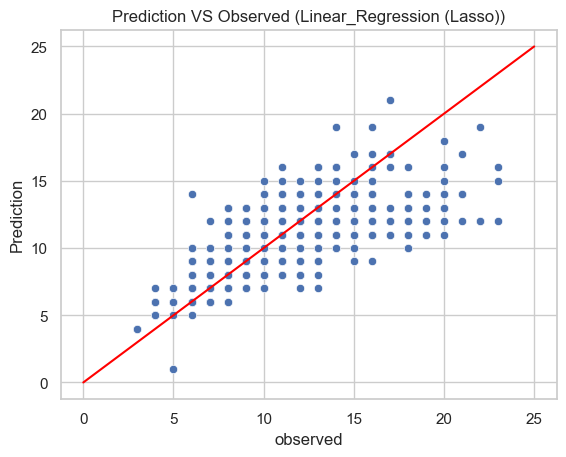

In [37]:
sns.scatterplot(x=y_test, y=lrlasso_test_pred_red)

plt.plot([0,25],[0,25], color='red')
plt.title('Prediction VS Observed (Linear_Regression (Lasso))')
plt.xlabel('observed')
plt.ylabel('Prediction')

In [38]:
# Coeficientes del modelo Lasso
lasso_mod = lasso_reg_optimo.named_steps['lasso']
coeficients = lasso_mod.coef_

# Intercepto (ordenada al origen)
intercept = lasso_mod.intercept_

columnas_numericas = columnas_continuas
columnas_categoricas_transformadas = list(lasso_reg_optimo.named_steps['preprocesador'].named_transformers_['onehot'].get_feature_names_out(columnas_categoricas))
columnas_transformadas = columnas_numericas + columnas_categoricas_transformadas

# Creación del DataFrame con los atributos y sus pesos (coeficientes)
atributes_weight = pd.DataFrame({
    'Atribute': columnas_transformadas,
    'Weight': coeficients
})

# Selección de características con coeficientes distintos de cero (es decir, características seleccionadas por Lasso)
features_selected = atributes_weight[atributes_weight['Weight'] != 0]

# Ordenar las características por valor absoluto del coeficiente (peso)
features_selected = features_selected.reindex(features_selected.Weight.abs().sort_values(ascending=False).index).reset_index(drop=True)


print(f"Intercept: {intercept}")
print("")

print("Las características seleccionadas junto a sus coeficientes fueron:")
print(features_selected)


Intercept: 10.183251482999875

Las características seleccionadas junto a sus coeficientes fueron:
         Atribute    Weight
0  Shucked_weight -3.074136
1    Shell_weight  1.838408
2    Whole_weight  1.657315
3          Height  0.962853
4           Sex_I -0.622549
5        Diameter  0.583739
6  Viscera_weight -0.274899


- **Coeficientes ordenados por importancia de forma descendente**

  - **`Shucked_weight` (-3.074)**: Un aumento de 1 unidad en `Shucked_weight` reduce `Rings` en aproximadamente 3.074.

  - **`Shell_weight` (1.838)**: Un aumento de 1 unidad en `Shell_weight` incrementa `Rings` en aproximadamente 1.838.

  - **`Whole_weight` (1.657)**: Un aumento de 1 unidad en `Whole_weight` incrementa `Rings` en aproximadamente 1.657.

  - **`Height` (0.963)**: Un aumento de 1 unidad en `Height` incrementa `Rings` en aproximadamente 0.963.

  - **`Sex_I` (-0.623)**: Un aumento de 1 unidad en `Sex_I` reduce `Rings` en aproximadamente 0.623.

  - **`Diameter` (0.584)**: Un incremento de 1 unidad en `Diameter` incrementa `Rings` en aproximadamente 0.584.
  
  - **`Viscera_weight` (-0.275)**: Un aumento de 1 unidad en `Viscera_weight` reduce `Rings` en aproximadamente 0.275.

  - El **`intercept` (10.183)** representa el valor de `Rings` cuando todos los atributos son cero; es un valor razonable que está en el rango que puede tomar el *target*.

Text(0.5, 1.0, 'Residue distribution')

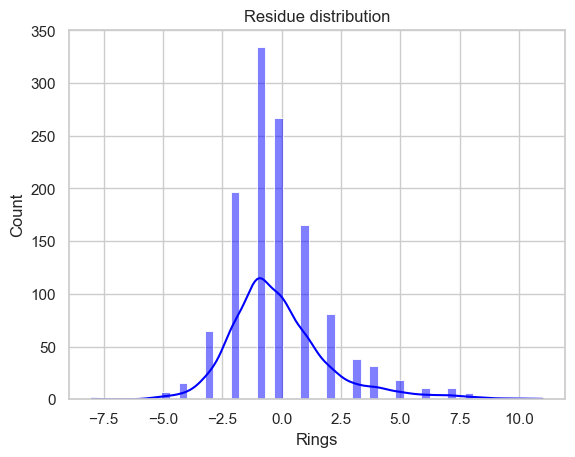

In [39]:
sns.histplot(x=residue, kde=True, color='blue')
plt.title('Residue distribution')

### Comparación de performance `Linear Regression` VS `Linear Regression (Lasso)`

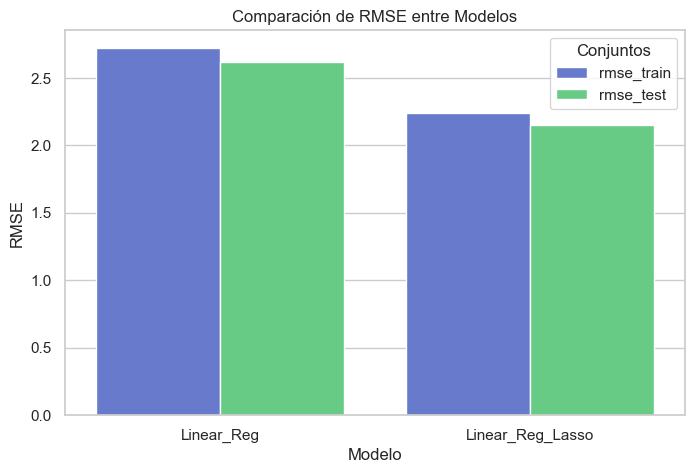

In [40]:

# Concatenar los DataFrames
performance_df = pd.concat([lr_perf_df, lrlasso_df])

# Configuración de estilo
sns.set(style="whitegrid")

palette_hls = sns.color_palette("hls", 8)  # Puedes ajustar el número de colores si deseas más variedad
blue_hls = palette_hls[5]  # Índice del azul en la paleta 'hls'
green_hls = palette_hls[3]  # Índice del verde en la paleta 'hls'

# Crear figura y ejes para gráficos lado a lado
plt.figure(figsize=(8, 5))

# Gráfico de barras para RMSE
rmse_data = performance_df[['model', 'rmse_train', 'rmse_test']].melt(id_vars='model', var_name='set', value_name='rmse')
ax = sns.barplot( x='model', y='rmse', hue='set', data=rmse_data, palette=[blue_hls, green_hls], hue_order=['rmse_train', 'rmse_test'])
ax.set_title('Comparación de RMSE entre Modelos')
ax.set_ylabel('RMSE')
ax.set_xlabel('Modelo')
ax.legend(title='Conjuntos')

plt.show()

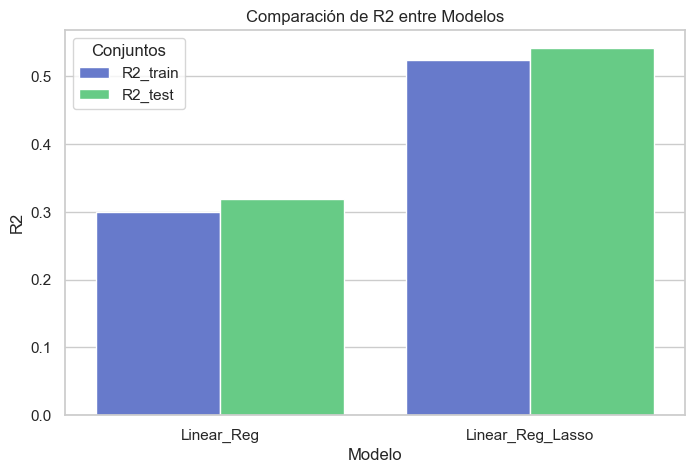

In [41]:
plt.figure(figsize=(8, 5))

r2_data = performance_df[['model', 'R2_train', 'R2_test']].melt(id_vars='model', var_name='set', value_name='R2')
ax = sns.barplot(x='model', y='R2', hue='set', data=r2_data, palette=[blue_hls, green_hls], hue_order=['R2_train', 'R2_test'])
ax.set_title('Comparación de R2 entre Modelos')
ax.set_ylabel('R2')
ax.set_xlabel('Modelo')
ax.legend(title='Conjuntos')

plt.show()

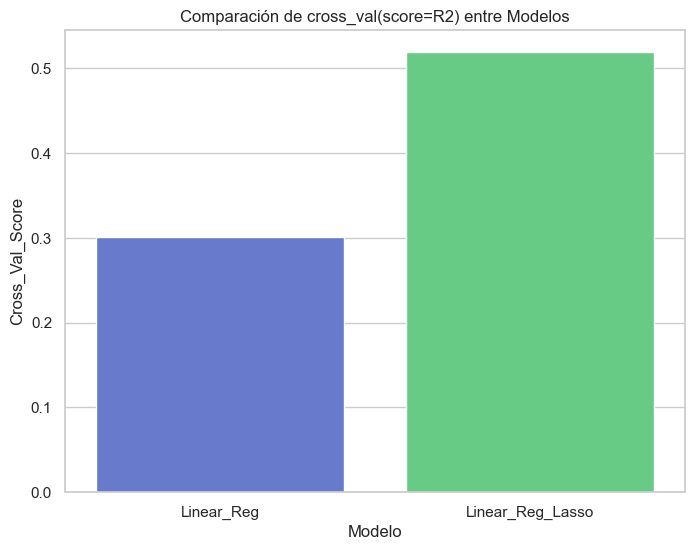

In [42]:
plt.figure(figsize=(8, 6))

cross_data = performance_df[['model', 'cv_score_mean']].melt(id_vars='model', value_name='cv_score_value')
ax = sns.barplot(x='model', y='cv_score_value', hue='model', data=cross_data, palette=[blue_hls, green_hls])
ax.set_title('Comparación de cross_val(score=R2) entre Modelos')
ax.set_ylabel('Cross_Val_Score')
ax.set_xlabel('Modelo')

plt.show()

### Conclusiones del Modelo `Linear Regression (Lasso)`

Observando las métricas de performance, podríamos concluir que el modelo `Linear Regression (Lasso)` tiene una mejor performance que `LinearRegression (Benchmark)`.

- **R²**
  - `Linear Regression (Lasso)` obtuvo un `R²` en test de ***0.541***, lo que representa una mejora del ***68.53%*** respecto al `R²` de `LinearRegression (Benchmark)`.

- **RMSE**
  - `Linear Regression (Lasso)` obtuvo un `RMSE` en test de ***2.148***, lo que representa una reducción del ***17.95%*** respecto a `LinearRegression`.

El modelo **`Linear Regression`** se ha destacado en comparación con el modelo de regresión lineal con dos variables **`LinearRegression (Benchmark)`**, especialmente por su habilidad para detectar nuevos patrones en los datos, reducir el error y mitigar el riesgo de subajuste.

Una cosa que queremos destacar es el hecho de que tanto en `LinearRegression` como en `Linear Regression (Lasso)`, el `RMSE` y `R²` dan peores resultados para el conjunto de entrenamiento en comparación con el conjunto de test; no pudimos encontrar una explicación a este comportamiento.

Observación: las predicciones del modelo `Linear Regression (Lasso)` devuelven valores continuos con coma, pero el *target* contra el que se comparan las predicciones tiene saltos discretos de 1 unidad, por lo que todas las predicciones fueron redondeadas según el criterio: *if (parte_decimal >= 5) → (valor_redondeado = parte_entera + 1); else (valor_redondeado = parte_entera)*.Si parte_decimal≥5parte_decimal≥5, entonces valor_redondeado=parte_entera+1valor_redondeado=parte_entera+1; de lo contrario, valor_redondeado=parte_enteravalor_redondeado=parte_entera.

## ¿Cómo continuaríamos el trabajo?

Para continuar nuestro trabajo, consideraríamos plantear modelos de ensamble como el **Stacking Regressor**, ya que estos modelos nos podrían permitir reducir el error al capturar patrones que los modelos anteriores no pudieron identificar, y de esta manera obtener una mejor performance y un menor error.

También plantearíamos comparaciones de modelos, teniendo en cuenta que algunas variables solo pueden obtenerse sacrificando al animal, mientras que otras no implican su muerte para obtenerse.


### Intergrantes del grupo 12
  - Ivan Lopez, mail: lopezivan1996@gmail.com
  - Bautista Turri, mail: turribautista551@gmail.com